<a href="https://colab.research.google.com/github/ggzlemos/pytorch_image_classification/blob/main/alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Classification using Pytorch and AlexNet

###In this notebook, I will be training two models based on AlexNet. For the first one I will only used the architecture of the Net, without pre-training. For the second one, I will use the pre-trained Network. In the end, I will compare the results.

#####PS.: References are listed in the end of the notebook




##For this experiment I choose the CIFAR10 dataset.

##According to it's official website (https://www.cs.toronto.edu/~kriz/cifar.html), this datase consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

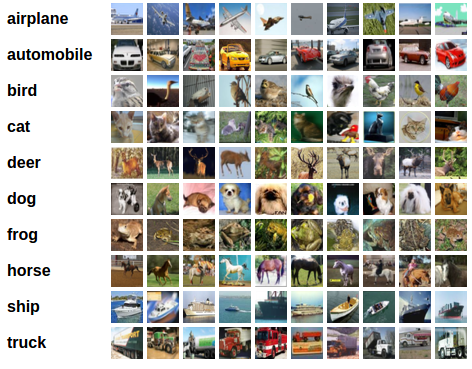



###Imports

In [ ]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models import alexnet
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import classification_report

###Setting device to cuda if it is avaliable. CPU otherwise

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

###This is the image transformation Pipeline. It resizes the images to 128x128.

In [ ]:
transformers = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

###Loading the data using torchvision

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data/train', train=True,
                                        download=True, transform=transformers)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data/test', train=False,
                                       download=True, transform=transformers)
testloader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/train/cifar-10-python.tar.gz to ./data/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


###Here is a function to reverse the transformation process so I could plot the original images for vizualizaion purposes only

In [ ]:
def revert_transform(img):
  inverse = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),])
  return inverse(img)


###Method for ploting the images

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Original Image:


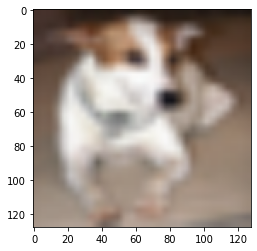

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Transformed Image:


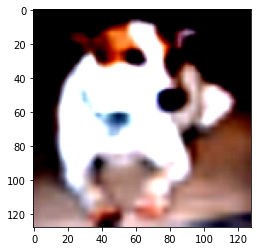

In [ ]:
dataiter = iter(trainloader)
train_images, labels = dataiter.next()

inv_tensor = revert_transform(train_images[0])

print('Original Image:')
imshow(inv_tensor)
print('\nTransformed Image:')
imshow(train_images[0])

##Here I a setting AlexNet. This code was taken from Pytorch documentation. Link can be found in the end of this notebook 

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
net = AlexNet(num_classes=len(trainset.classes)).to(device)

###Method for traing the 2 models I'll be using for this experiment

In [ ]:
def train_model(model, trainloader, criterion, learning_rate=0.01, epochs=20):
  train_history_loss = []
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)

  for epoch in range(epochs):
    for i, data in enumerate(trainloader):

      inputs, labels = data
      optimizer.zero_grad()
      outputs = model(inputs.to(device))
      train_loss = criterion(outputs.to(device), labels.to(device))
      train_loss.backward()
      optimizer.step()

      train_history_loss.append(train_loss.item())

      print(f'Epoch: {epoch} - Loss: {train_history_loss[-1]}')
  return train_history_loss        


##Method for making predictions

In [ ]:
def predict(model, testloader):
  with torch.no_grad():

    y_test, y_pred = [], []

    for data in testloader:

        X_test_batch, y_test_batch  = data
        y_pred_raw_batch            = model(X_test_batch.to('cuda'))
        _, y_pred_batch             = torch.max(y_pred_raw_batch, 1)

        y_test += list([x.item() for x in y_test_batch])
        y_pred += list([x.item() for x in y_pred_batch])

    return y_test, y_pred  


In [ ]:
def plot_error(train_history):
  plt.plot(train_history )

##Traing the first model: AlexNet without pre-training

In [ ]:
criterion = nn.CrossEntropyLoss()
train_history = train_model(net, trainloader, criterion, learning_rate=0.01, epochs=10)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch: 9 - Loss: 0.259718656539917
Epoch: 9 - Loss: 0.2419387847185135
Epoch: 9 - Loss: 0.1269364207983017
Epoch: 9 - Loss: 0.1810925453901291
Epoch: 9 - Loss: 0.4253760576248169
Epoch: 9 - Loss: 0.8658026456832886
Epoch: 9 - Loss: 0.32949814200401306
Epoch: 9 - Loss: 0.08957052230834961
Epoch: 9 - Loss: 0.6584059000015259
Epoch: 9 - Loss: 0.03939083218574524
Epoch: 9 - Loss: 0.07030752301216125
Epoch: 9 - Loss: 0.04408646002411842
Epoch: 9 - Loss: 0.27687233686447144
Epoch: 9 - Loss: 0.095070481300354
Epoch: 9 - Loss: 1.329724907875061
Epoch: 9 - Loss: 0.33449041843414307
Epoch: 9 - Loss: 0.20534946024417877
Epoch: 9 - Loss: 0.04566511511802673
Epoch: 9 - Loss: 0.001581170130521059
Epoch: 9 - Loss: 0.28152212500572205
Epoch: 9 - Loss: 0.05390733480453491
Epoch: 9 - Loss: 0.35647517442703247
Epoch: 9 - Loss: 0.39373520016670227
Epoch: 9 - Loss: 0.20804712176322937
Epoch: 9 - Loss: 0.5640571713447571
Epoch: 9 - Loss: 0.010924845

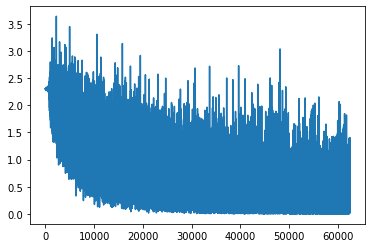

In [ ]:
plot_error(train_history)

In [ ]:
y_test, y_pred = predict(net, testloader)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1000
           1       0.90      0.90      0.90      1000
           2       0.80      0.65      0.72      1000
           3       0.61      0.66      0.64      1000
           4       0.77      0.75      0.76      1000
           5       0.66      0.75      0.70      1000
           6       0.90      0.76      0.83      1000
           7       0.86      0.82      0.84      1000
           8       0.84      0.90      0.87      1000
           9       0.89      0.84      0.86      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



##Traing the second model: Pre-trained AlexNet

In [ ]:
alexnet_pre = alexnet(pretrained=True).to(device)
alexnet_pre

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
criterion = nn.CrossEntropyLoss()
train_history = train_model(alexnet_pre, trainloader, criterion, learning_rate=0.01, epochs=5)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch: 4 - Loss: 0.14907090365886688
Epoch: 4 - Loss: 0.0076163290068507195
Epoch: 4 - Loss: 0.3379092216491699
Epoch: 4 - Loss: 0.4279986023902893
Epoch: 4 - Loss: 0.03914913162589073
Epoch: 4 - Loss: 0.7140425443649292
Epoch: 4 - Loss: 0.37848562002182007
Epoch: 4 - Loss: 0.00730083417147398
Epoch: 4 - Loss: 0.353726863861084
Epoch: 4 - Loss: 0.11300334334373474
Epoch: 4 - Loss: 0.5763920545578003
Epoch: 4 - Loss: 0.050582606345415115
Epoch: 4 - Loss: 0.1884545087814331
Epoch: 4 - Loss: 0.0012784871505573392
Epoch: 4 - Loss: 0.019389206543564796
Epoch: 4 - Loss: 0.04987482354044914
Epoch: 4 - Loss: 0.5417788028717041
Epoch: 4 - Loss: 0.03143041953444481
Epoch: 4 - Loss: 0.03578457981348038
Epoch: 4 - Loss: 0.544732391834259
Epoch: 4 - Loss: 0.14311832189559937
Epoch: 4 - Loss: 0.039012279361486435
Epoch: 4 - Loss: 0.5761076807975769
Epoch: 4 - Loss: 0.10408901423215866
Epoch: 4 - Loss: 0.23672282695770264
Epoch: 4 - Loss: 0.0

In [ ]:
y_test, y_pred = predict(alexnet_pre, testloader)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1000
           1       0.92      0.92      0.92      1000
           2       0.83      0.79      0.81      1000
           3       0.81      0.62      0.70      1000
           4       0.85      0.86      0.85      1000
           5       0.71      0.85      0.78      1000
           6       0.88      0.91      0.89      1000
           7       0.84      0.90      0.87      1000
           8       0.92      0.87      0.90      1000
           9       0.94      0.87      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



##So, for the 1st experiment, The not pre-trained model achieved an accuracy of 79%. That's a good result by itself, but it still can be improved, especially when it comes to state-of-the-art image classifiers. 

##As for the 2nd experiment, the pre-trained model achvieved an accuracy of 85%, while being trained with less training epochs. Even though both models were trained with a low number of epchs, it is still an improvement.



##Referências

[Training a Classifier - Pytorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

[CIFAR10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html)

[Simple way to inverse transform - forum](https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821)

[Pytorch - AlexNet source code](https://pytorch.org/vision/main/_modules/torchvision/models/alexnet.html)

[Redes Neurais Convolucionais - H2IA](https://www.youtube.com/watch?v=ujrwBSG9bI0&list=PLmKrb8DwBTiVfW5yX93K5HP0N_aVdguuA&index=7)

[Implementando Redes Neurais Convolucionais - H2IA](https://www.youtube.com/watch?v=n1rw8l7vN5c&list=PLmKrb8DwBTiVfW5yX93K5HP0N_aVdguuA&index=8)

[AlexNet - Paper](https://dl.acm.org/doi/10.1145/3065386)

